# Tarea 2

In [143]:
# Import necessary libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

# For visualization
import seaborn as sns


## Load and Preprocess Images:

In [144]:
# Load the images 
# img_fragments = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
# img_pellets = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
# img_tar = cv2.imread('tar-03-olympus-10-01-2020.JPG')

img_fragments = cv2.imread('FRA.png')
img_pellets = cv2.imread('PEL.png')
img_tar = cv2.imread('TAR.png')

# Convert images to grayscale
gray_fragments = cv2.cvtColor(img_fragments, cv2.COLOR_BGR2GRAY)
gray_pellets = cv2.cvtColor(img_pellets, cv2.COLOR_BGR2GRAY)
gray_tar = cv2.cvtColor(img_tar, cv2.COLOR_BGR2GRAY)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [145]:
# Gaussian Blur to reduce noise and improve thresholding
blur_fragments = cv2.GaussianBlur(gray_fragments, (3, 3), sigmaX=1.0)
blur_pellets = cv2.GaussianBlur(gray_pellets, (3, 3), sigmaX=1.0)
blur_tar = cv2.GaussianBlur(gray_tar, (3, 3), sigmaX=1.0)

### Morphological Opening:

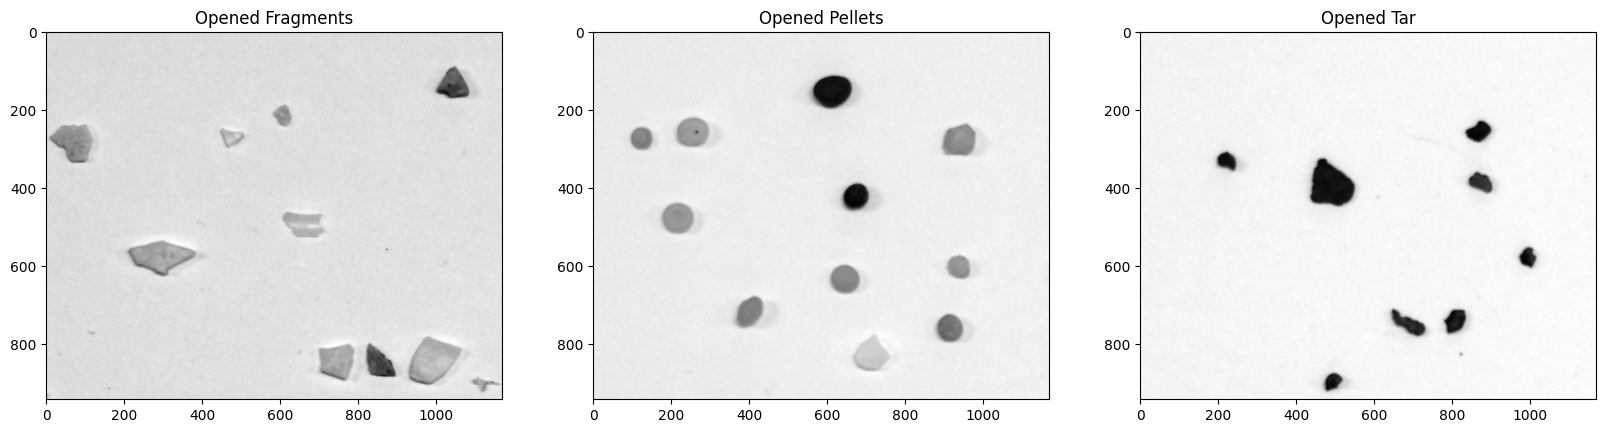

In [147]:
# Define a kernel for morphological operations
kernel = np.ones((3, 3), np.uint8)

# Apply opening to remove small objects and noise
opening_fragments = cv2.morphologyEx(blur_fragments, cv2.MORPH_OPEN, kernel, iterations=2)
opening_pellets = cv2.morphologyEx(blur_pellets, cv2.MORPH_OPEN, kernel, iterations=2)
opening_tar = cv2.morphologyEx(blur_tar, cv2.MORPH_OPEN, kernel, iterations=2)

# Print the opened images
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(opening_fragments, cmap='gray')
plt.title('Opened Fragments')
plt.subplot(132)
plt.imshow(opening_pellets, cmap='gray')
plt.title('Opened Pellets')
plt.subplot(133)
plt.imshow(opening_tar, cmap='gray')
plt.title('Opened Tar')
plt.show()

### Thresholding and Inversion:

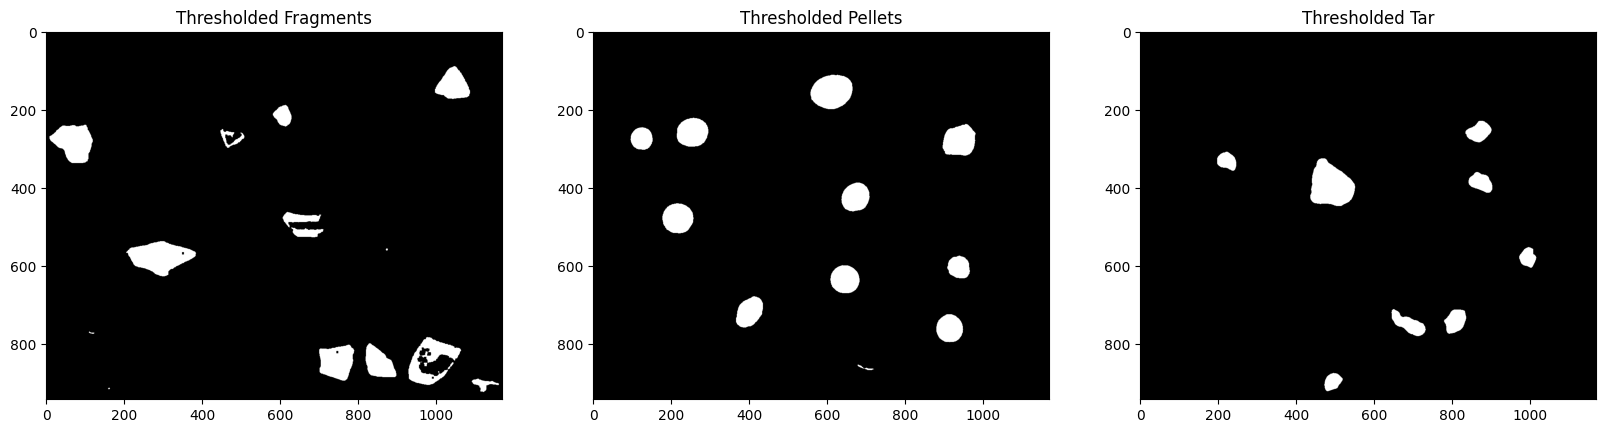

In [148]:
# Apply Otsu's thresholding
_, thresh_fragments = cv2.threshold(opening_fragments, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, thresh_pellets = cv2.threshold(opening_pellets, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, thresh_tar = cv2.threshold(opening_tar, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert images (particles should be white)
thresh_fragments = cv2.bitwise_not(thresh_fragments)
thresh_pellets = cv2.bitwise_not(thresh_pellets)
thresh_tar = cv2.bitwise_not(thresh_tar)

# Print the thresholded and inverted images
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(thresh_fragments, cmap='gray')
plt.title('Thresholded Fragments')
plt.subplot(132)
plt.imshow(thresh_pellets, cmap='gray')
plt.title('Thresholded Pellets')
plt.subplot(133)
plt.imshow(thresh_tar, cmap='gray')
plt.title('Thresholded Tar')
plt.show()

### Contour Detection:

In [151]:
# Find contours for each image
contours_fragments, _ = cv2.findContours(thresh_fragments, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_pellets, _ = cv2.findContours(thresh_pellets, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_tar, _ = cv2.findContours(thresh_tar, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Max area for fragments: 9435.0
Max area for pellets: 7261.5
Max area for tar: 9728.0


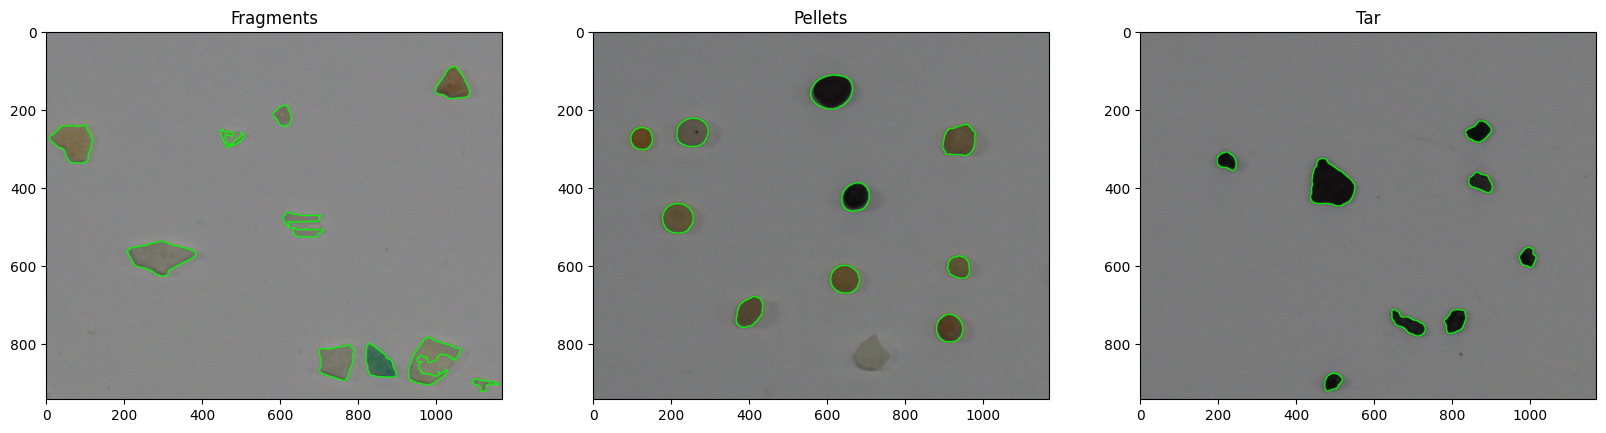

In [152]:
# Set a minimum area threshold to filter out noise
min_area = 600
max_area = 20000

# Filter contours based on area
filtered_fragments = [cnt for cnt in contours_fragments if cv2.contourArea(cnt) > min_area and cv2.contourArea(cnt) < max_area]
filtered_pellets = [cnt for cnt in contours_pellets if cv2.contourArea(cnt) > min_area and cv2.contourArea(cnt) < max_area]
filtered_tar = [cnt for cnt in contours_tar if cv2.contourArea(cnt) > min_area and cv2.contourArea(cnt) < max_area]

# Create a copy of the original images
fragments_copy = img_fragments.copy()
pellets_copy = img_pellets.copy()
tar_copy = img_tar.copy()

# Draw the filtered contours on the copies
cv2.drawContours(fragments_copy, filtered_fragments, -1, (0, 255, 0), 2)
cv2.drawContours(pellets_copy, filtered_pellets, -1, (0, 255, 0), 2)
cv2.drawContours(tar_copy, filtered_tar, -1, (0, 255, 0), 2)

# Print max area for each image
print('Max area for fragments:', max([cv2.contourArea(cnt) for cnt in filtered_fragments]))
print('Max area for pellets:', max([cv2.contourArea(cnt) for cnt in filtered_pellets]))
print('Max area for tar:', max([cv2.contourArea(cnt) for cnt in filtered_tar]))

# Print the images with the contours
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(cv2.cvtColor(fragments_copy, cv2.COLOR_BGR2RGB))
plt.title('Fragments')
plt.subplot(132)
plt.imshow(cv2.cvtColor(pellets_copy, cv2.COLOR_BGR2RGB))
plt.title('Pellets')
plt.subplot(133)
plt.imshow(cv2.cvtColor(tar_copy, cv2.COLOR_BGR2RGB))
plt.title('Tar')
plt.show()

## Feature Extraction

In [153]:
def extract_features(contour):
    features = {}
    # Area
    area = cv2.contourArea(contour)
    features['area'] = area

    # Perimeter
    perimeter = cv2.arcLength(contour, True)
    features['perimeter'] = perimeter

    # Compactness
    if area != 0:
        compactness = (perimeter ** 2) / area
    else:
        compactness = 0
    features['compactness'] = compactness

    # Bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h != 0 else 0
    features['aspect_ratio'] = aspect_ratio

    # Extent (area ratio)
    rect_area = w * h
    extent = area / rect_area if rect_area != 0 else 0
    features['extent'] = extent

    # Ellipse axes ratio
    if len(contour) >= 5:
        ellipse = cv2.fitEllipse(contour)
        (center, axes, orientation) = ellipse
        major_axis = max(axes)
        minor_axis = min(axes)
        ellipse_axis_ratio = minor_axis / major_axis if major_axis != 0 else 0
        features['ellipse_axis_ratio'] = ellipse_axis_ratio
    else:
        features['ellipse_axis_ratio'] = 0

    return features

In [154]:
# Initialize a list to store data
data = []

# Process fragments
for contour in filtered_fragments:
    features = extract_features(contour)
    features['label'] = 'Fragment'
    data.append(features)

# Process pellets
for contour in filtered_pellets:
    features = extract_features(contour)
    features['label'] = 'Pellet'
    data.append(features)

# Process tar
for contour in filtered_tar:
    features = extract_features(contour)
    features['label'] = 'Tar'
    data.append(features)

# Create a DataFrame
df = pd.DataFrame(data)


In [155]:
from scipy import stats

# Calculate the Z-scores for each feature
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))

# Set a threshold for identifying outliers
threshold = 1.5

# Filter out rows that have Z-scores above the threshold
df_clean = df[(z_scores < threshold).all(axis=1)]

      area   perimeter  compactness  aspect_ratio    extent  \
1   6142.5  327.722869    17.485109      0.978261  0.741848   
2   4378.0  280.793937    18.009419      0.908046  0.636985   
8   7330.0  355.220344    17.214392      1.132653  0.673837   
9   1712.5  165.923880    16.076341      0.857143  0.637091   
10  4772.5  284.835567    16.999749      1.071429  0.631283   

    ellipse_axis_ratio     label  
1             0.938694  Fragment  
2             0.513968  Fragment  
8             0.825381  Fragment  
9             0.808139  Fragment  
10            0.934487  Fragment  
             area   perimeter  compactness  aspect_ratio     extent  \
count    21.00000   21.000000    21.000000     21.000000  21.000000   
mean   3751.02381  234.599156    15.529235      1.014674   0.708806   
std    1802.26462   60.506129     1.160926      0.109694   0.055203   
min    1461.50000  150.610172    14.148697      0.830189   0.631283   
25%    2331.50000  188.509666    14.492211      0.958333

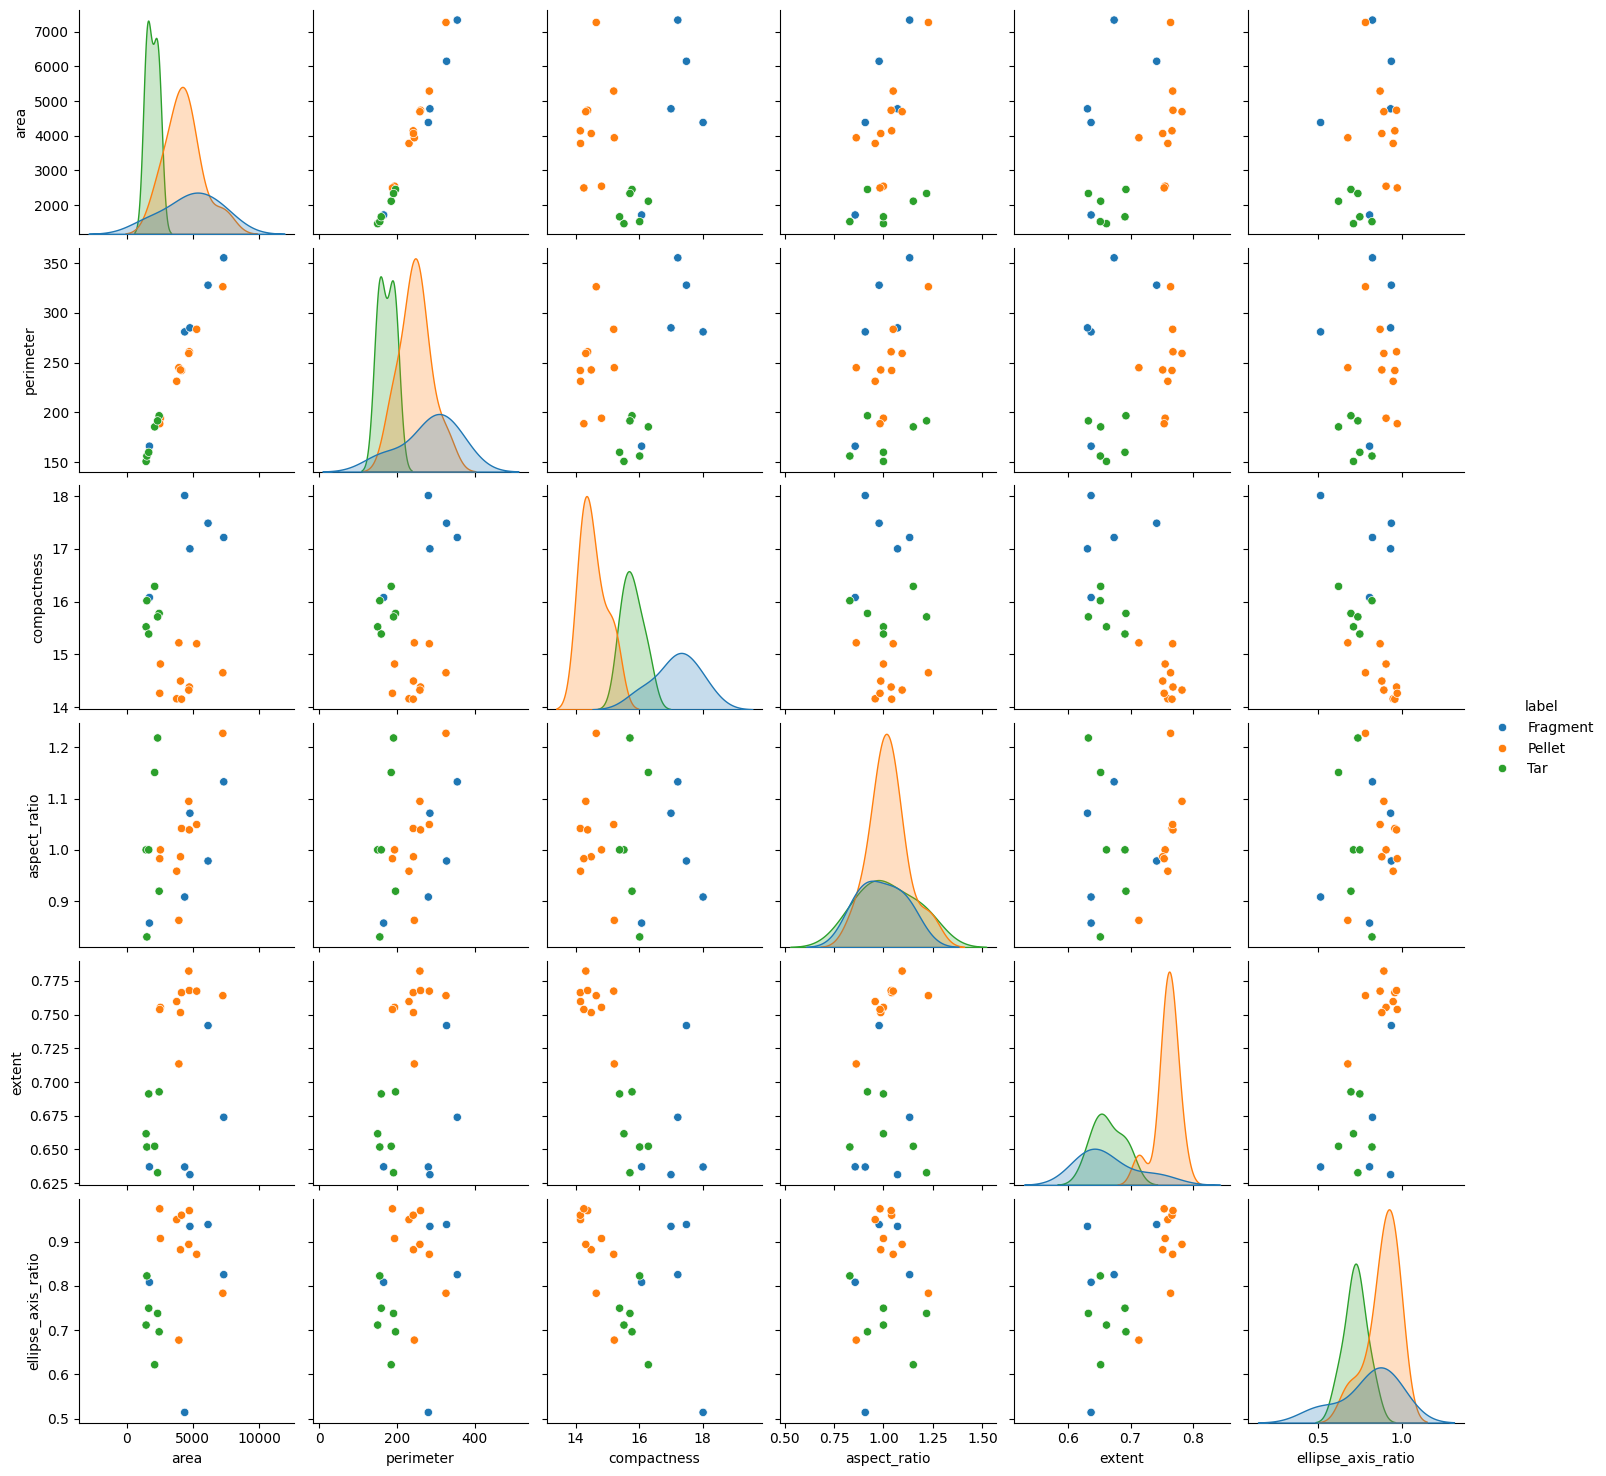

In [156]:
# Display first few rows
print(df_clean.head())

# Statistical summary
print(df_clean.describe())

# Visualize feature distribution
sns.pairplot(df_clean, hue='label')
plt.show()

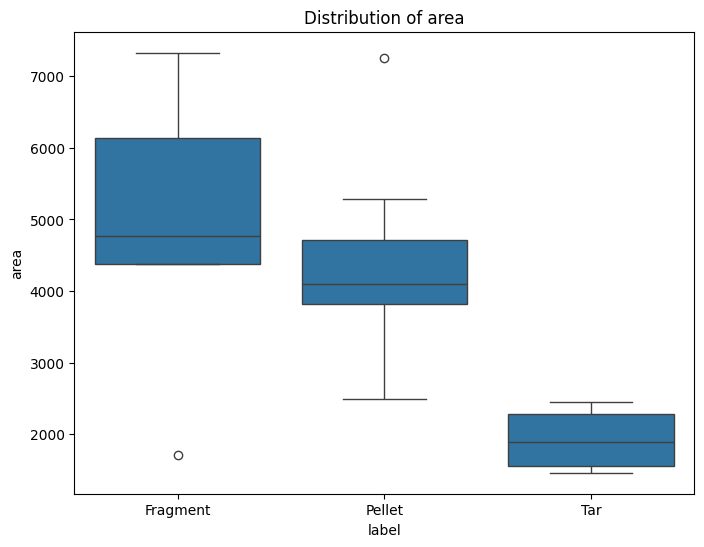

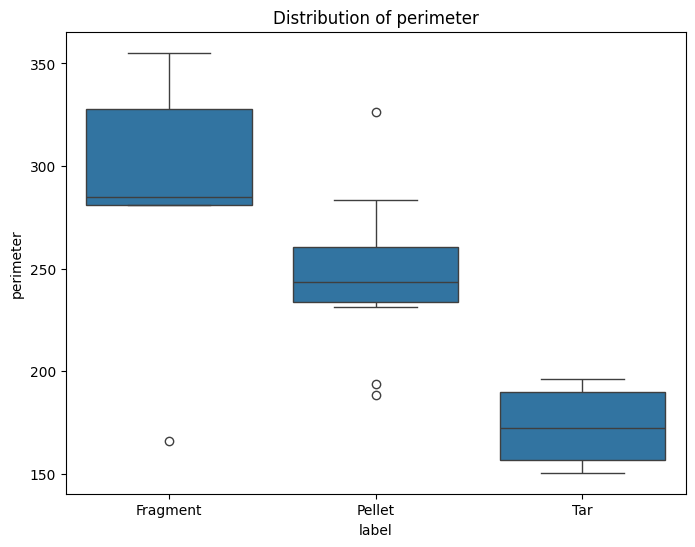

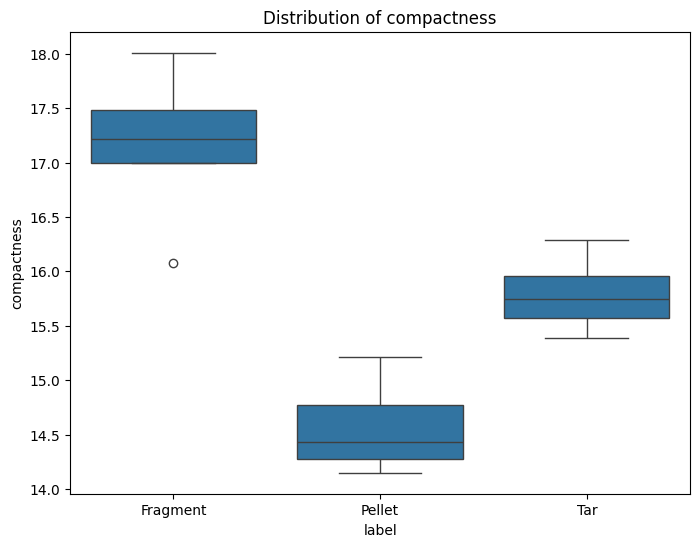

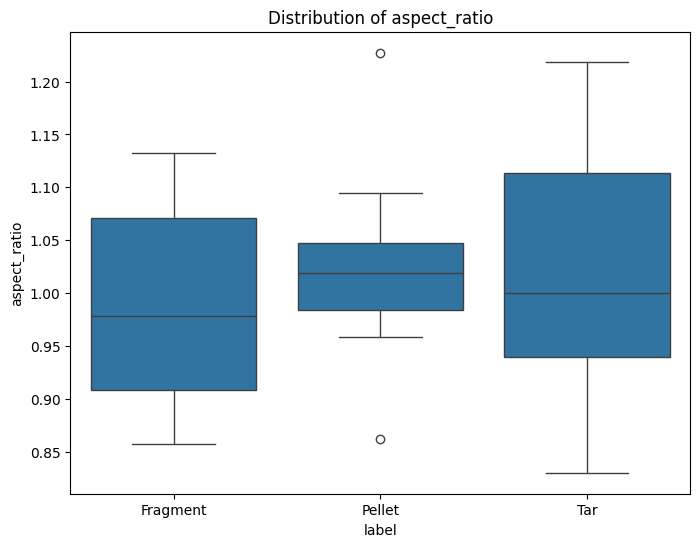

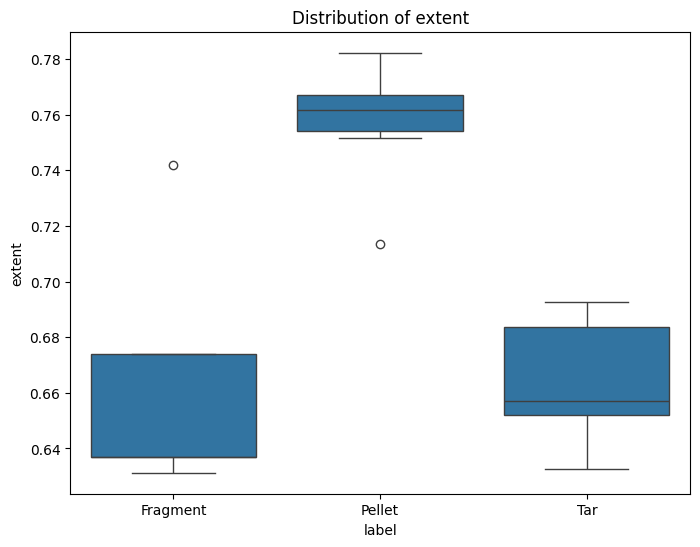

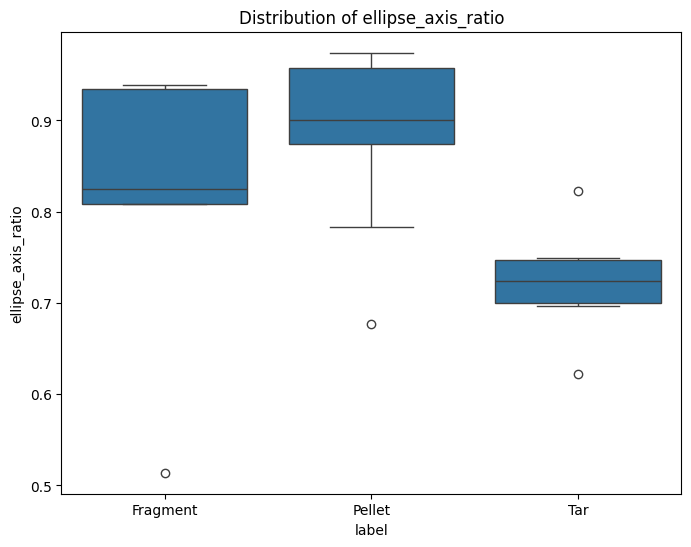

In [157]:
# Boxplots for each feature
features = ['area', 'perimeter', 'compactness', 'aspect_ratio', 'extent', 'ellipse_axis_ratio']

for feature in features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='label', y=feature, data=df_clean)
    plt.title(f'Distribution of {feature}')
    plt.show()

In [123]:
# Calculate mean and std per class
grouped = df_clean.groupby('label').agg(['mean', 'std'])
print(grouped)

             area                perimeter            compactness            \
             mean          std        mean        std        mean       std   
label                                                                         
Fragment  4850.40  2103.179510  283.222364  74.800753   17.191983  0.911330   
Pellet    4283.85  1372.200322  246.001549  40.091968   14.440059  0.400985   
Tar       1917.25   431.123503  172.445537  20.245045   15.666321  0.369533   

         aspect_ratio              extent           ellipse_axis_ratio  \
                 mean       std      mean       std               mean   
label                                                                    
Fragment     1.001020  0.108563  0.673081  0.043042           0.807788   
Pellet       1.026251  0.099786  0.771255  0.019898           0.885292   
Tar          1.028811  0.139741  0.677618  0.031061           0.724361   

                    
               std  
label               
Fragment  0.16714

In [158]:
def classifier(features):
    # Extract feature values
    compactness = features['compactness']
    aspect_ratio = features['aspect_ratio']
    ellipse_axis_ratio = features['ellipse_axis_ratio']
    extent = features['extent']
    
    # Thresholds based on feature distributions (adjusted to avoid overlap)
    compactness_fragment_threshold = 17  # Threshold for Fragment (slightly below Fragment mean)
    compactness_pellet_threshold = 16    # Threshold for Pellet (slightly below Pellet mean)
    extent_fragment_threshold = 0.68     # Threshold for Fragment based on extent
    extent_pellet_threshold = 0.75       # Threshold for Pellet
    ellipse_axis_ratio_pellet_threshold = 0.8  # Pellet has higher axis ratio
    aspect_ratio_fragment_threshold = 1.1     # Fragment generally has higher aspect ratios
    
    # Classification logic
    if compactness > compactness_fragment_threshold:
        return 'Fragment'
    elif compactness > compactness_pellet_threshold:
        if extent > extent_pellet_threshold:
            return 'Pellet'
        else:
            return 'Tar'
    else:
        if ellipse_axis_ratio > ellipse_axis_ratio_pellet_threshold:
            return 'Pellet'
        elif aspect_ratio > aspect_ratio_fragment_threshold and extent > extent_fragment_threshold:
            return 'Fragment'
        else:
            return 'Tar'


In [159]:
# Apply the classifier to each particle
df_clean.loc[:, 'predicted_label'] = df_clean.apply(classifier, axis=1)

/var/folders/qq/bpt2j0x16rz0xjhcf0x6w0hm0000gn/T/ipykernel_5203/3412644502.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'predicted_label'] = df_clean.apply(classifier, axis=1)


In [160]:
from sklearn.metrics import confusion_matrix, classification_report

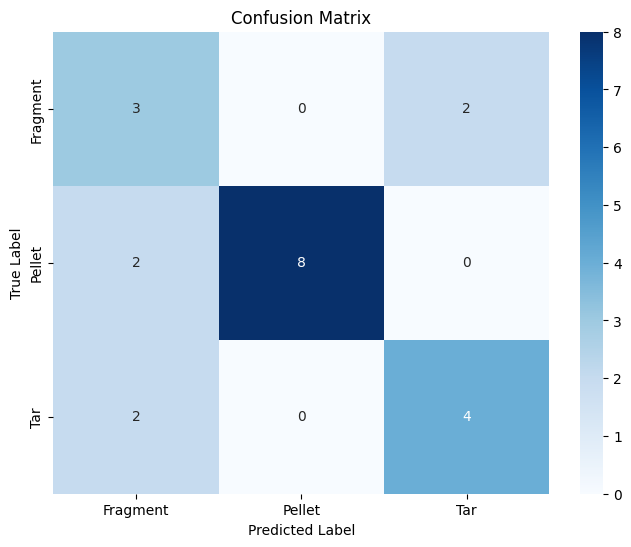

              precision    recall  f1-score   support

    Fragment       0.43      0.60      0.50         5
      Pellet       1.00      0.80      0.89        10
         Tar       0.67      0.67      0.67         6

    accuracy                           0.71        21
   macro avg       0.70      0.69      0.69        21
weighted avg       0.77      0.71      0.73        21



In [162]:
# Actual labels
y_true = df_clean['label']
# Predicted labels
y_pred = df_clean['predicted_label']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['Fragment', 'Pellet', 'Tar'])

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Fragment', 'Pellet', 'Tar'], yticklabels=['Fragment', 'Pellet', 'Tar'], cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))

In [133]:
# Function to classify and visualize particles in an image
def classify_and_visualize(original_img, contours):
    img_output = original_img.copy()
    for contour in contours:
        # Extract features
        features = extract_features(contour)
    
        # Predict the label using manual classifier
        predicted_label = classifier(features)
    
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
    
        # Draw rectangle and label
        cv2.rectangle(img_output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img_output, predicted_label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Convert BGR to RGB for plotting
    img_rgb = cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Classification Results')
    plt.show()


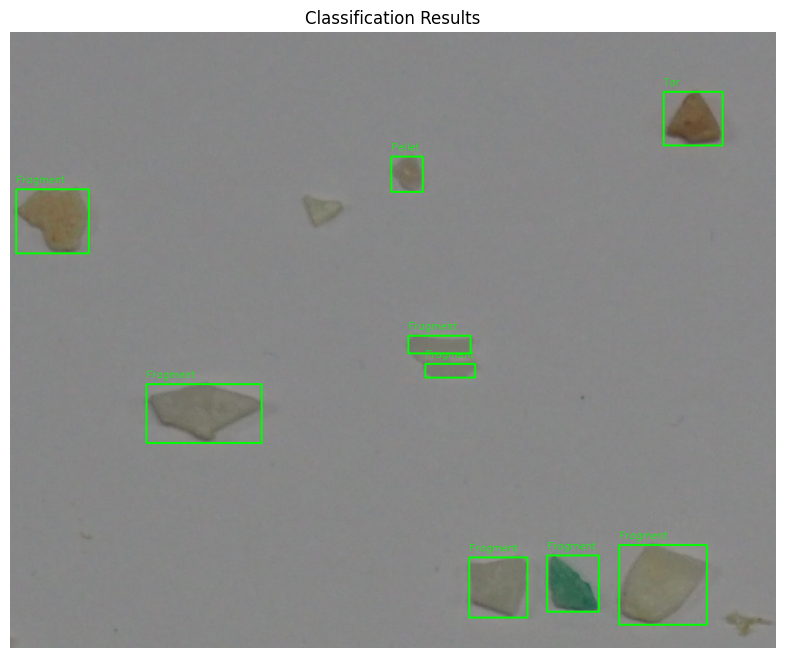

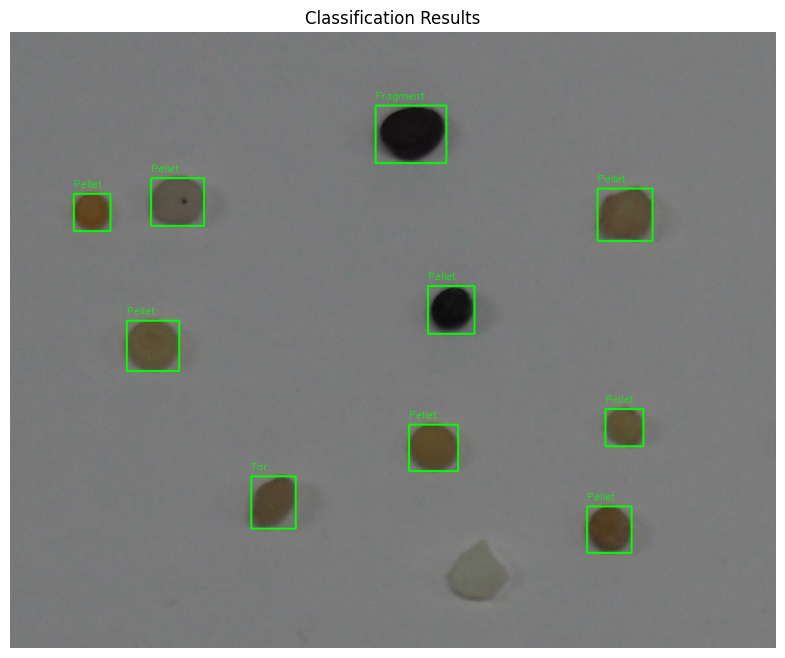

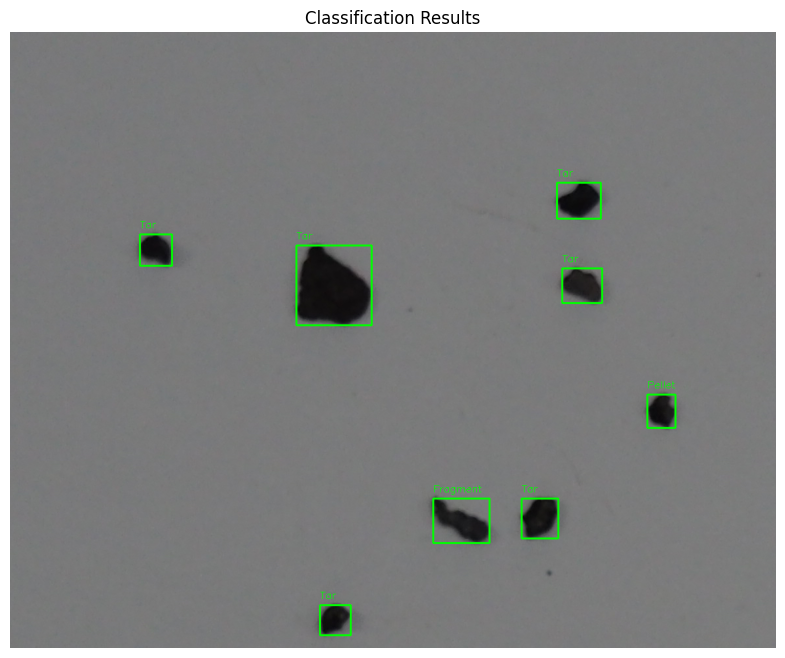

In [134]:
# Visualize results on the fragments image
classify_and_visualize(img_fragments, filtered_fragments)

# Visualize results on the pellets image
classify_and_visualize(img_pellets, filtered_pellets)

# Visualize results on the tar image
classify_and_visualize(img_tar, filtered_tar)
